<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 24px;">ML-Based Leaf Area Estimation</h1>
</div>

**Explanation of the Research:**

   **Aim: to predict the mean leaf area of a rooted grape cutting of Vitis vinifera L. cv Pinot noir cultivated in Odesa region basing on the number of shoots, mean shoot length and mean leaf amount.**
   
   **When dealing with large quantities of rooted cuttings, measuring their mean leaf areas becomes challenging, consuming substantial time and resources. To address this issue, it becomes promising to attempt predicting the mean leaf area using easily measurable morphological characteristics: the quantity of green shoots, shoot length, leaf amount of the cuttings and vigorousity of the plant. This more manageable approach underscores the purpose of this study.** 


<div style="background-color: #b9deab; padding: 10px;">
    <h1 style="font-size: 24px;">EDA of Grape Morphology Dataset
</div>

<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Importing Modules
</div>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import pickle

from flaml import AutoML

import os
import sys

import warnings
warnings.filterwarnings("ignore")

<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Reading and Primary Description of the Data 
</div>

**Explanation of Column Names:**

   - **shoots_amount_mean**: amount of green shoots per a rooted wooden cutting
   - **shoots_length_mean**: mean length of green shoots per a rooted cutting, cm
   - **leaves_amount_mean**: mean amount of leaves per a rooted cutting
   - **vigorous**: vigorousity of a plant ('0' - the plant is not vigorous, '1' - the plant is vigorous)
   - **leaf_area_mean**: mean leaf area per one rooted cutting, cm^2


In [2]:
# Read the data file
grapes = pd.read_csv(r'C:\Users\liman\Documents\My Data Science\data\area_grape_leaves.csv')
grapes.head(4)

,shoots_amount_mean,shoots_length_mean,leaves_amount_mean,vigorous,leaf_area_mean
0,1.0,3.50,3.0,0,5.42
1,2.0,3.70,3.0,0,5.69
2,2.0,32.00,8.5,0,2.70
3,2.0,6.65,4.0,0,8.55


In [3]:
# Primary description 
grapes.shape

(1751, 5)

In [4]:
grapes.describe()

,shoots_amount_mean,shoots_length_mean,leaves_amount_mean,vigorous,leaf_area_mean
count,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000
mean,1.938321,9.477601,5.285208,0.178184,6.005745
std,0.866961,6.989059,2.382252,0.382777,4.883368
min,1.000000,1.000000,1.000000,0.000000,0.370000
25%,1.000000,4.750000,3.670000,0.000000,2.910000
50%,2.000000,7.300000,5.000000,0.000000,4.220000
75%,2.000000,11.800000,6.500000,0.000000,7.660000
max,5.000000,39.000000,14.000000,1.000000,25.860000


<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Pairwise Relationships of the Features
</div>

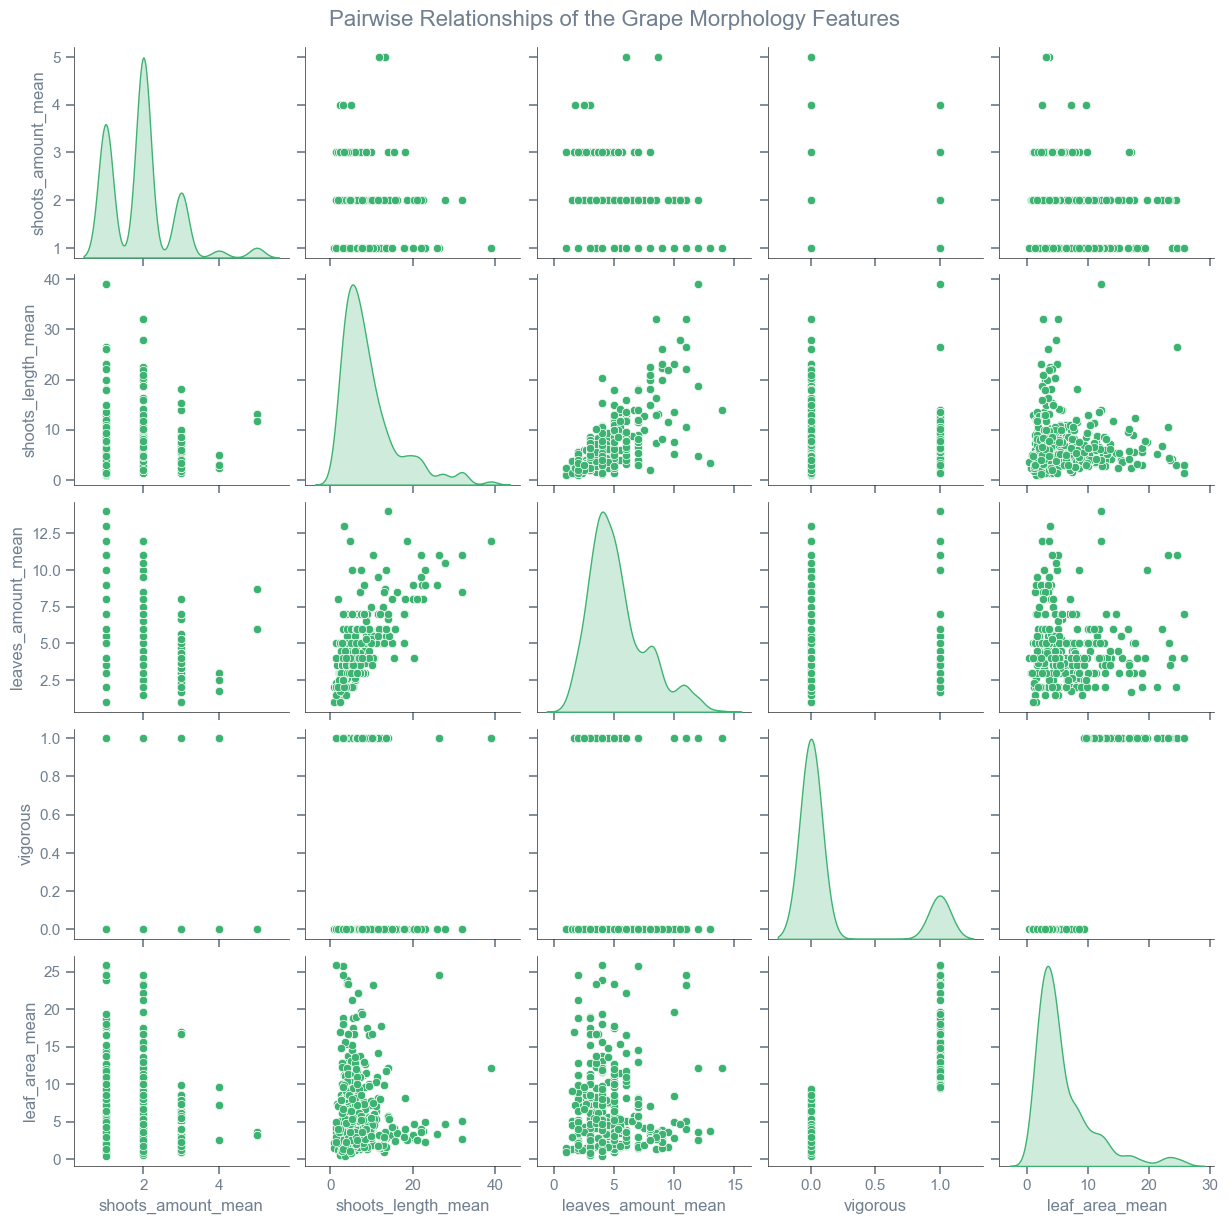

In [5]:
# Set the plot style
sns.set(
    style='ticks', 
    color_codes=True, 
    rc={'axes.linewidth': 0.5, 
        'xtick.color': 'slategray', 
        'ytick.color': 'slategray', 
        'axes.labelcolor': 'slategray'}
)

# Create a pairplot 
sns.pairplot(
    grapes, 
    diag_kind='kde', 
    plot_kws={'color': 'mediumseagreen'},
    diag_kws={'color': 'mediumseagreen'}
)

plt.suptitle(
    'Pairwise Relationships of the Grape Morphology Features', 
    fontsize=16, 
    color='slategray'
)

# Adjust the spacing between the plots and the suptitle
plt.subplots_adjust(top=0.95);

<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Heat Map of the Grape Morphology Features
</div>

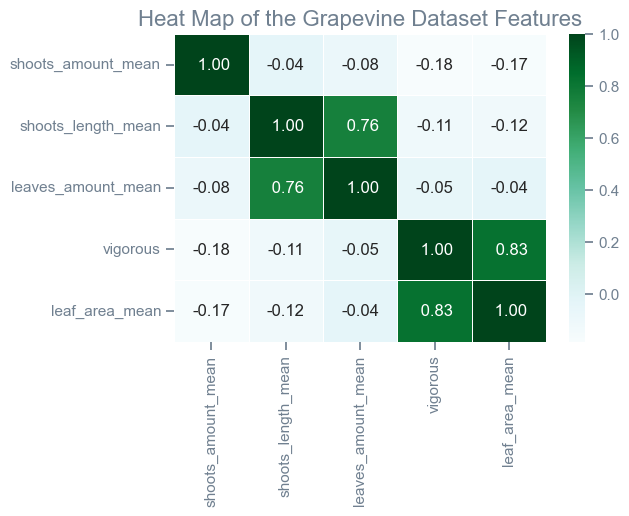

In [6]:
# Calculate the correlation matrix with Pearson coefficients
correlation_matrix=grapes.corr()

# Set the color style
cmap=sns.color_palette('BuGn', as_cmap=True)

# Create the heat map
plt.figure(figsize=(6, 4))

sns.heatmap(
    correlation_matrix, 
    cmap=cmap, 
    annot=True, 
    fmt=' .2f', 
    linewidths=0.5
)

plt.title(
    'Heat Map of the Grapevine Dataset Features', 
    fontsize=16, 
    color='slategray'
);

**CONCLUSION from the Pairplot and the Heatmap of the Features:**
 - **The correlation was observed between**:
    - **Vigorousity state of the plant and leaf area: Pearson coefficient = 0.83. This feature will be very important for succesful predictions (see visualization below).**
    
    - **Mean lengths of shoots and mean leaves amount with Pearson correlation coefficient = 0.76 (see the detailed plot below).**
    
    - **Unfortunately there is no sufficient higher correlation between leaf area and other morphological characteristics. The correlation coefficients of -0.17, -0.12 and -0.04 suggest weak or negligible associations (see the heatmap above).**

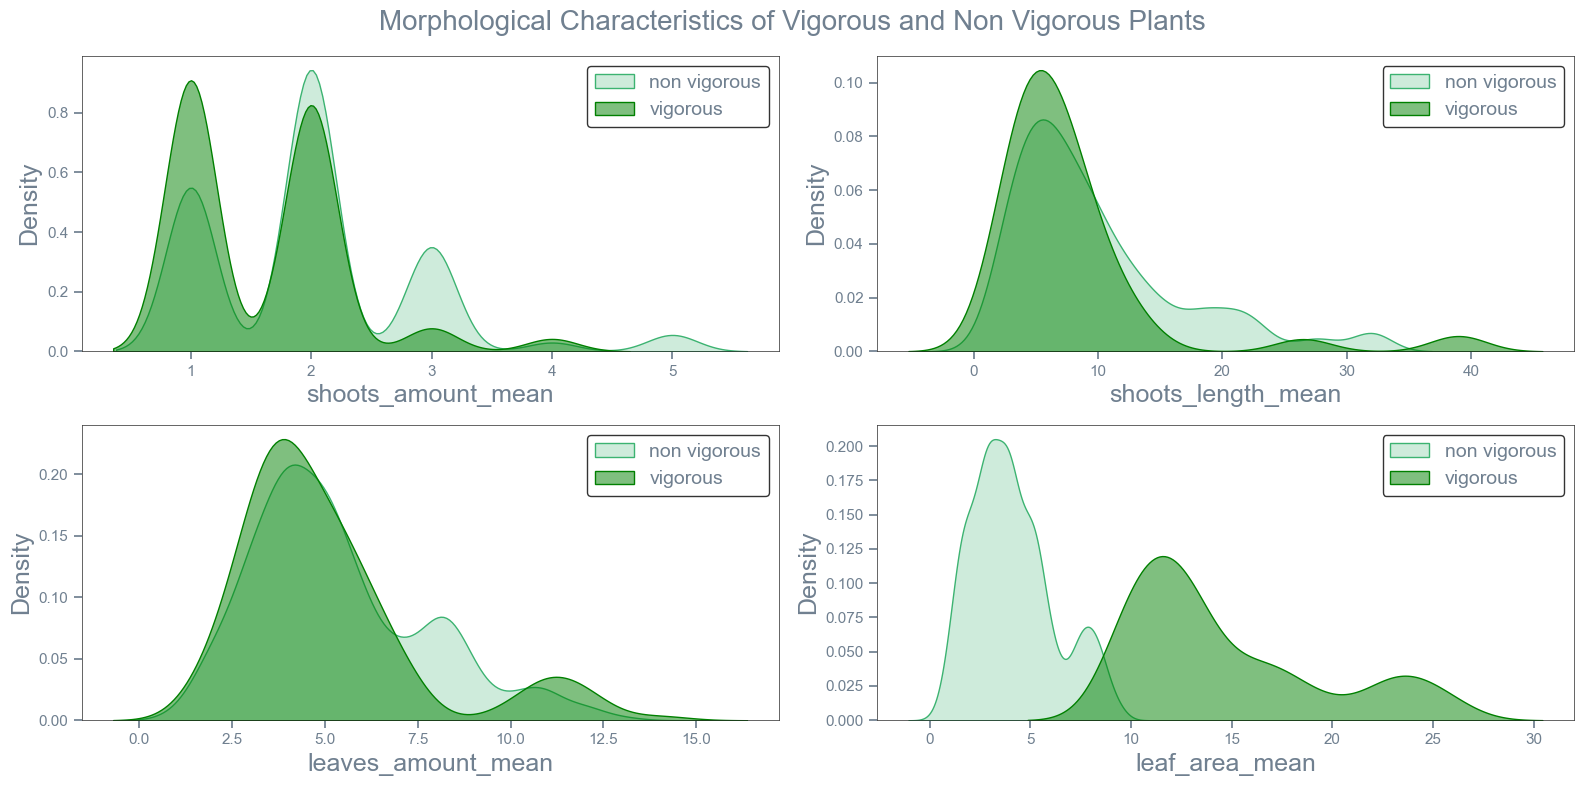

In [7]:
# Create plots describing relationship between 'vigorous' and other features

# Create two datasets for vigorous '1' or '0'
grapes_0 = grapes[grapes['vigorous'] == 0]
grapes_1 = grapes[grapes['vigorous'] == 1]

# Plot the needed kde 
columns = [
    'shoots_amount_mean', 
    'shoots_length_mean', 
    'leaves_amount_mean',
    'leaf_area_mean'
]

# Create a grid of subplots
num_plots = len(columns)
num_rows = num_plots // 2 + (num_plots % 2 > 0)
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(16, num_rows*4))

# Iterate over each column and create KDE plot
for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax = sns.kdeplot(
        grapes_0[column], 
        color='mediumseagreen', 
        label='non vigorous', 
        fill=True, 
        ax=ax, 
        warn_singular=False
    )
    
    ax = sns.kdeplot(
        grapes_1[column], 
        color='green', 
        alpha=0.5, 
        label='vigorous', 
        fill=True, 
        ax=ax, 
        warn_singular=False
    )
    
    ax.legend(
        fontsize=14, 
        loc='upper right', 
        frameon=True, 
        facecolor='white', 
        edgecolor='black'
    )
    
    ax.set_xlabel(column, fontsize=18)
    ax.set_ylabel('Density', fontsize=18)

    # Set legend text color 
    for text in ax.legend_.get_texts():
        text.set_color('slategray')

# Remove empty subplots
if num_plots < num_rows * 2:
    for i in range(num_plots, num_rows * 2):
        fig.delaxes(axes.flatten()[i])
        
plt.suptitle(
    'Morphological Characteristics of Vigorous and Non Vigorous Plants', 
    color = 'slategray',
    fontsize = 20
)

plt.tight_layout()

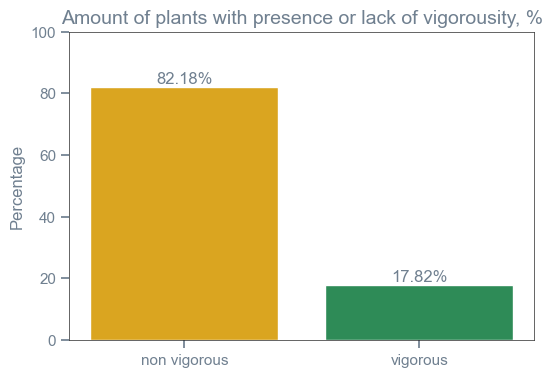

In [8]:
# Calculate value counts with normalization
value_counts = grapes['vigorous'].value_counts(normalize=True)

# Access the percentage of 0s and 1s
percentage_0 = value_counts[0] * 100
percentage_1 = value_counts[1] * 100

# Define the data
categories = ['non vigorous', 'vigorous']
percentages = [percentage_0, percentage_1]

# Define the colors for the bars
colors = ['goldenrod', 'seagreen']

# Create the bar plot
plt.figure(figsize = (6, 4))

plt.bar(categories, percentages, color=colors)

# Set y-axis limits to extend up to 100
plt.ylim(0, 100)

# Set plot title and labels
plt.title(
    'Amount of plants with presence or lack of vigorousity, %', 
    fontsize = 14, 
    color ='slategray'
)

plt.ylabel('Percentage', fontsize=12)

# Add percentage values above the bars
for i, val in enumerate(percentages):
    plt.text(
        i, 
        val, 
        f'{val:.2f}%', 
        ha ='center', 
        va ='bottom', 
        fontsize = 12,
        color ='slategray'
    )

<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Characterization of the Target Feature: leaf_area_mean
</div>

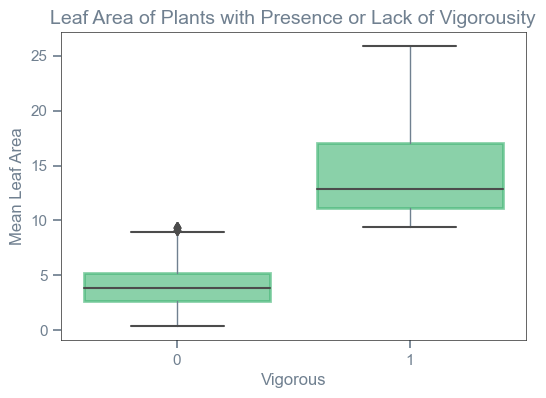

In [9]:
# Create a boxplot
 
plt.figure(figsize=(6, 4))
  
# Set the color for boxplot lines and error lines
boxprops = dict(linewidth=2, color='mediumseagreen', alpha=0.6)
whiskerprops = dict(linewidth=1, color='slategray')
   
sns.boxplot(
    x="vigorous", 
    y="leaf_area_mean", 
    data=grapes, 
    boxprops=boxprops, 
    whiskerprops=whiskerprops
)

plt.xlabel('Vigorous', fontsize=12, color='slategray')
plt.ylabel('Mean Leaf Area', fontsize=12, color='slategray')

plt.title(
    'Leaf Area of Plants with Presence or Lack of Vigorousity', 
    fontsize=14, 
    color='slategray'
);

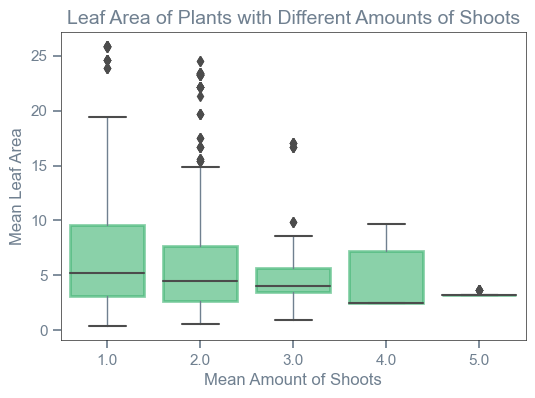

In [10]:
# Create a boxplot
 
plt.figure(figsize=(6, 4))
  
# Set the color for boxplot lines and error lines
boxprops = dict(linewidth=2, color='mediumseagreen', alpha=0.6)
whiskerprops = dict(linewidth=1, color='slategray')
   
sns.boxplot(
    x="shoots_amount_mean", 
    y="leaf_area_mean", 
    data=grapes, 
    boxprops=boxprops, 
    whiskerprops=whiskerprops
)

plt.xlabel('Mean Amount of Shoots', fontsize=12, color='slategray')
plt.ylabel('Mean Leaf Area', fontsize=12, color='slategray')

plt.title(
    'Leaf Area of Plants with Different Amounts of Shoots', 
    fontsize=14, 
    color='slategray'
);

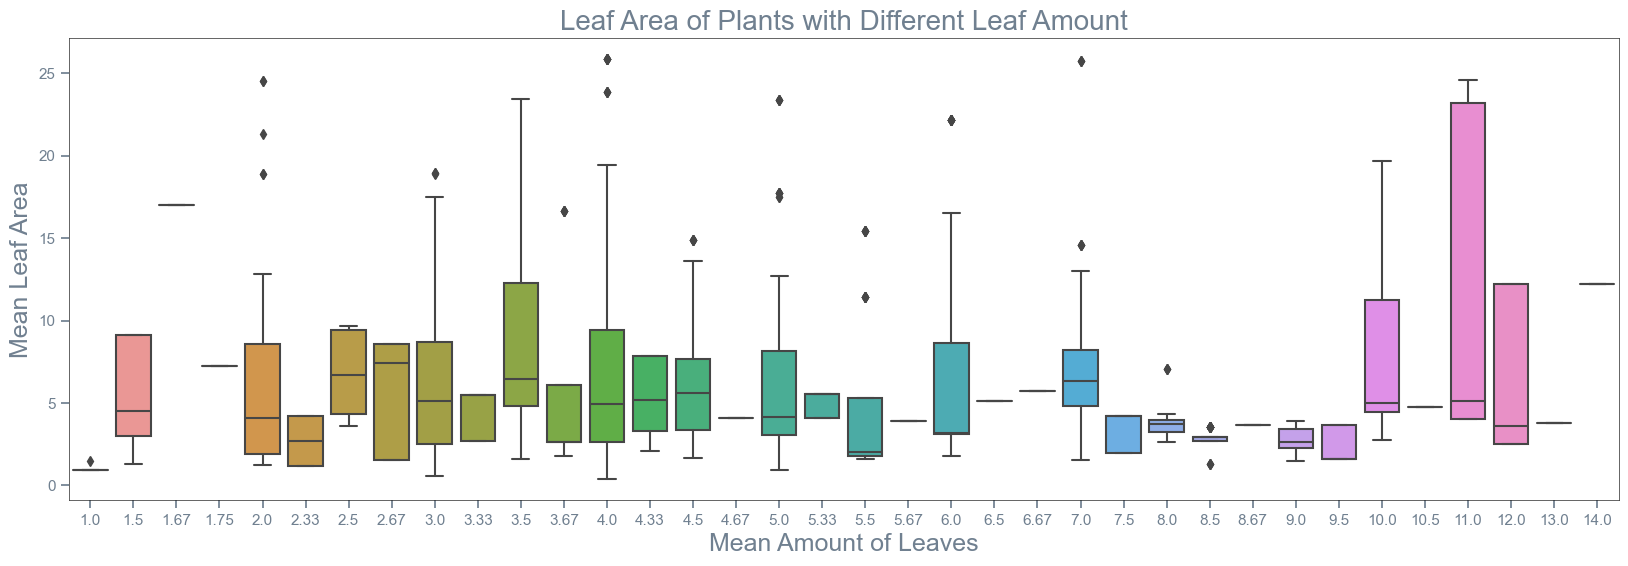

In [11]:
# Create a box plot
    
plt.figure(figsize=(20, 6))
   
sns.boxplot(x="leaves_amount_mean", y="leaf_area_mean", data=grapes)
    
plt.xlabel('Mean Amount of Leaves', fontsize=18, color='slategray')
plt.ylabel('Mean Leaf Area', fontsize=18, color='slategray')

plt.title(
    'Leaf Area of Plants with Different Leaf Amount', 
    fontsize=20, 
    color='slategray'
);

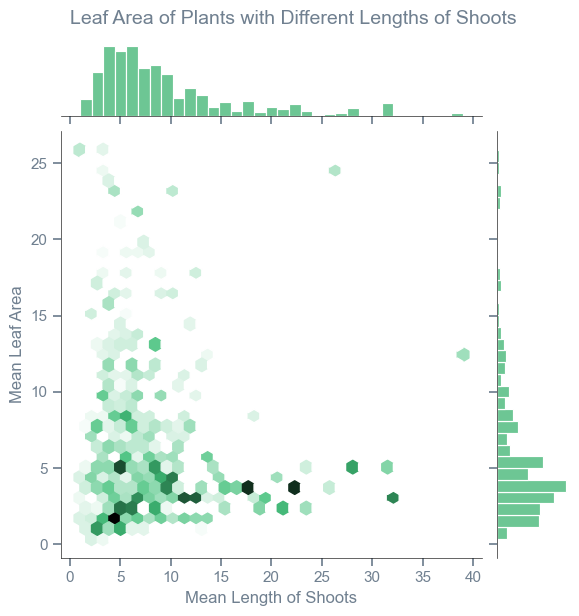

In [12]:
# Create a joint plot
  
j = sns.jointplot(
    x='shoots_length_mean', 
    y='leaf_area_mean', 
    data=grapes,  
    kind='hex', 
    color='mediumseagreen'
)
   
plt.xlabel('Mean Length of Shoots', fontsize=12, color='slategray')
plt.ylabel('Mean Leaf Area', fontsize=12, color='slategray')
   
# Add a custom text annotation as a title patch
plt.gca().annotate(
    'Leaf Area of Plants with Different Lengths of Shoots', 
    xy=(1, 1), 
    xytext=(0, j.ax_joint.get_ylim()[1] + 7),  
    xycoords='axes fraction', 
    textcoords='data', 
    color='slategray', 
    fontsize=14
    );

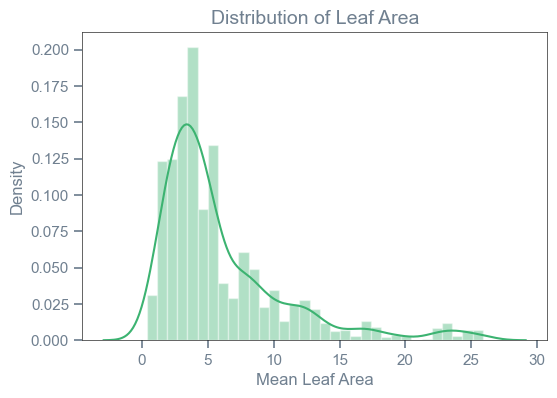

In [13]:
# Create a KDE plot of the target feature
  
plt.figure(figsize=(6, 4))

sns.distplot(grapes['leaf_area_mean'], color='mediumseagreen')
 
plt.title('Distribution of Leaf Area', fontsize=14, color='slategray')
plt.xlabel('Mean Leaf Area', fontsize=12)
plt.ylabel('Density', fontsize=12);

**CONCLUSIONS from the Visualization of the Target Feature:**

- **There are numerous outliers of leaf area values - mainly in plants with the smallest amount fo shoots (1-2) and in plants with amount of leaves from 2 to 7;**
   
   
- **Shoots with lengths from 2 to 12 cm approx yielded the higher leaf areas more frequently than other lengths;**
   
   
- **The KDE plot of leaf areas exhibits a long right tail.**

<div style="background-color: #b9deab; padding: 10px;">
    <h1 style="font-size: 24px;">ML Regression 
</div>

<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Selecting the Optimal ML Model on Raw Initial Data
</div>

In [14]:
# Shuffle the dataset 
grapes_shuffled = grapes.sample(frac=1, random_state=42) 

In [15]:
# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [16]:
# Separate the data
X = grapes_shuffled.drop(['leaf_area_mean'], axis=1)
y = grapes_shuffled['leaf_area_mean']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
# Scale the input data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [18]:
# Define models in a list to cycle over them and create a dict with all metrics
models = [
    ('Linear Regression', LinearRegression()),
    ('SVR', SVR()),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('Decision Tree Regressor', DecisionTreeRegressor()),
    ('Random Forest Regressor', RandomForestRegressor()),
    ('XGBoost Regressor', XGBRegressor()),
    ('LGBM Regressor', LGBMRegressor()),
    ('Gradient Boosting Regressor', GradientBoostingRegressor()),
    ('Ridge Regressor', Ridge()),
    ('K-Nearest Neighbors', KNeighborsRegressor()),
    ('AdaBoost Regressor', AdaBoostRegressor()),
    ('Extra Trees Regressor', ExtraTreesRegressor()),
    ]
 
# Create an empty list to store the results for each model
results = []
fitted_models = {}  # Store fitted models
 
# Loop over each model
for name, model in models:
    # Set the random seed for the model
    model.random_state = random_seed

   # Fit the model on the train data
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the train and validation data
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)

    # Calculate the metrics - do not use CV because the dataset is small 
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    
    # Store the fitted model
    fitted_models[name] = model
    
    # Append the results for the model to the list
    results.append({
            'Model': name,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'mae': mae,
            'mse': mse,
            'rmse': rmse
    }
    )

# Create a df from the list of dictionaries
df_metrics = pd.DataFrame(results)

# Sort the df by MAE
df_metrics_sorted = df_metrics.sort_values(by='mae')
df_metrics_sorted

,Model,train_r2,val_r2,mae,mse,rmse
11,Extra Trees Regressor,0.988797,0.968783,0.252170,0.656994,0.810552
3,Decision Tree Regressor,0.988797,0.966193,0.267258,0.711505,0.843508
5,XGBoost Regressor,0.987850,0.967444,0.343948,0.685178,0.827755
4,Random Forest Regressor,0.986483,0.964927,0.372404,0.738146,0.859154
2,KNeighborsRegressor,0.936526,0.893706,0.836792,2.237054,1.495678
9,K-Nearest Neighbors,0.936526,0.893706,0.836792,2.237054,1.495678
6,LGBM Regressor,0.946655,0.911460,0.904597,1.863402,1.365065
7,Gradient Boosting Regressor,0.870042,0.851577,1.325422,3.123708,1.767402
1,SVR,0.685158,0.700343,1.687417,6.306588,2.511292
10,AdaBoost Regressor,0.731982,0.725106,1.927847,5.785413,2.405289


In [19]:
# Get the model with the lowest MAE (best model)
best_model_row = df_metrics_sorted.iloc[0]

# Get the name of the best model
best_model_name = best_model_row['Model']

# Find the corresponding model instance from the models list
best_model_instance = next(
    model for model_name, 
    model in models 
    if model_name == best_model_name
)

#'best_model_instance' contains the best-fitted model
print(f"The best model is: {best_model_instance}")

The best model is: ExtraTreesRegressor(random_state=42)


In [20]:
# Testing the best model on the test, independend dataset

# Read the test dataset
test = pd.read_csv(r'C:\Users\liman\Documents\My Data Science\data\test_data_leaf_area_grape.csv')
test

,shoots_amount_mean,shoots_length_mean,leaves_amount_mean,vigorous,leaf_area_mean
0,2.0,32.00,11.00,0,5.11
1,3.0,5.67,3.67,0,1.80
2,1.0,3.40,13.00,0,3.81
3,2.0,2.85,5.00,1,9.99
4,1.0,22.00,11.00,0,4.03
...,...,...,...,...,...
304,2.0,3.95,2.50,0,6.65
305,1.0,8.50,4.00,0,6.72
306,2.0,22.50,8.00,0,3.75
307,3.0,6.03,2.67,0,7.41


In [21]:
# Separate the data
X_test = test.drop('leaf_area_mean',  axis=1)
y_test= test['leaf_area_mean']

In [22]:
# Scale the data
X_test_scaled = scaler.transform(X_test)

In [23]:
# Use the trained model for predictions on test dataset
y_pred_test = best_model_instance.predict(X_test_scaled)

# Evaluate the best model on the test set
test_score = best_model_instance.score(X_test_scaled, y_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print("Model:", best_model_instance)
print("Test score:", test_score)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

Model: ExtraTreesRegressor(random_state=42)
Test score: 0.9532499860376615
MAE: 0.2634645647664158
MSE: 1.1032308278335559
RMSE: 1.050347955600217


**CONCLUSIONS from Model Selection on Row Initial Data:**

- **According to the analysis of the ML results, the most promising model appears to be the Extra Trees Regressor.**
   
   
- **While the validation data showed very good metrics, the independent (test) dataset exhibited lower r^2 score and higher MAE possibly indicating overfitting.**


- **Preprocessing of the initial dataset is needed to improve the best model metrics**.

<div style="background-color: #b9deab; padding: 10px;">
    <h1 style="font-size: 24px;">Feature Engineering 
</div>

**Taking into account the peculiarities of grape plant morphology, it is possible to create additional features that describe the specificity of each rooted cutting based on known characteristics:**

In [24]:
#  A new feature, 'leaf_coeff,' which describes the relationship between the vigor 
# of the cutting and the length of its shoots.

grapes['length_vigor_coeff'] = (grapes['vigorous'] + 
                        grapes['shoots_length_mean']) / \
                        grapes['shoots_length_mean']
grapes.head(4)

,shoots_amount_mean,shoots_length_mean,leaves_amount_mean,vigorous,leaf_area_mean,length_vigor_coeff
0,1.0,3.50,3.0,0,5.42,1.0
1,2.0,3.70,3.0,0,5.69,1.0
2,2.0,32.00,8.5,0,2.70,1.0
3,2.0,6.65,4.0,0,8.55,1.0


In [25]:
# A new feature, 'shoot_coeff', which describes the relationship between shoot amount,
# vigor and shoot length via leaf_coeff

grapes['amount_vigor_coeff'] = grapes['shoots_amount_mean']**2 / \
                        (grapes['length_vigor_coeff']**2  + 
                         grapes['vigorous'])**2 

grapes.head(4)           

,shoots_amount_mean,shoots_length_mean,leaves_amount_mean,vigorous,leaf_area_mean,length_vigor_coeff,amount_vigor_coeff
0,1.0,3.50,3.0,0,5.42,1.0,1.0
1,2.0,3.70,3.0,0,5.69,1.0,4.0
2,2.0,32.00,8.5,0,2.70,1.0,4.0
3,2.0,6.65,4.0,0,8.55,1.0,4.0


<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Heat Map with the New Features
</div>

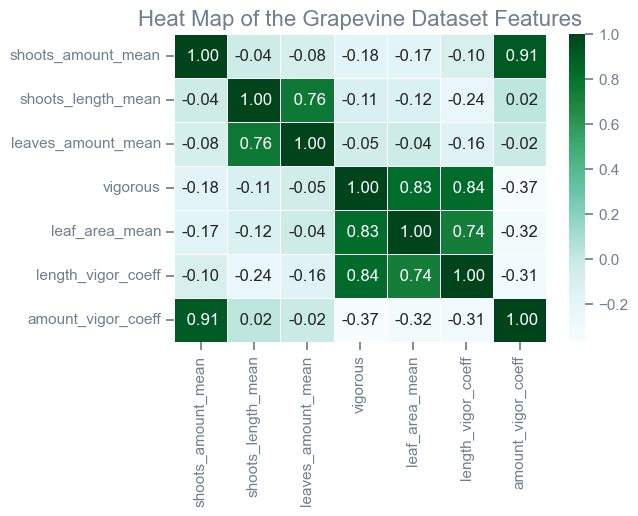

In [26]:
# Calculate the correlation matrix with Pearson coefficients
correlation_matrix=grapes.corr()

# Set the color style
cmap=sns.color_palette('BuGn', as_cmap=True)

# Create the heat map
plt.figure(figsize=(6, 4))

sns.heatmap(
    correlation_matrix, 
    cmap=cmap, 
    annot=True, 
    fmt=' .2f', 
    linewidths=0.5
)

plt.title(
    'Heat Map of the Grapevine Dataset Features', 
    fontsize=16, 
    color='slategray'
);

**CONCLUSION from the Heatmap with the New Features:**

 - **A noticeable correlation exists between the target feature, leaf_mean_area, and the new features: 0.74 with length_vigor_coeff and -0.32 with amount_vigor_coeff. These new features could prove helpful for prediction.**

<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Selecting the Optimal ML Model on Data with the New Features
</div>

In [27]:
# Shuffle the dataset 
grapes_shuffled = grapes.sample(frac=1, random_state=42) 

In [28]:
# Separate the data
X = grapes_shuffled.drop(['leaf_area_mean'], axis=1)
y = grapes_shuffled['leaf_area_mean']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [29]:
# Scale the input data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [30]:
# Define models in a list to cycle over them and create a dict with all metrics
models = [
    ('Linear Regression', LinearRegression()),
    ('SVR', SVR()),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('Decision Tree Regressor', DecisionTreeRegressor()),
    ('Random Forest Regressor', RandomForestRegressor()),
    ('XGBoost Regressor', XGBRegressor()),
    ('LGBM Regressor', LGBMRegressor()),
    ('Gradient Boosting Regressor', GradientBoostingRegressor()),
    ('Ridge Regressor', Ridge()),
    ('K-Nearest Neighbors', KNeighborsRegressor()),
    ('AdaBoost Regressor', AdaBoostRegressor()),
    ('Extra Trees Regressor', ExtraTreesRegressor()),
    ]
 
# Create an empty list to store the results for each model
results = []
fitted_models = {}  # Store fitted models
 
# Loop over each model
for name, model in models:
    # Set the random seed for the model
    model.random_state = random_seed

   # Fit the model on the train data
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the train and validation data
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)

    # Calculate the metrics - do not use CV because the dataset is small and CV gives worse 
    # results when using the trained model on independend test data
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    
    # Store the fitted model
    fitted_models[name] = model
    
    # Append the results for the model to the list
    results.append({
            'Model': name,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'mae': mae,
            'mse': mse,
            'rmse': rmse
    }
    )

# Create a df from the list of dictionaries
df_metrics = pd.DataFrame(results)

# Sort the df by MAE
df_metrics_sorted = df_metrics.sort_values(by='mae')
df_metrics_sorted

,Model,train_r2,val_r2,mae,mse,rmse
11,Extra Trees Regressor,0.988797,0.969849,0.247628,0.634550,0.796587
3,Decision Tree Regressor,0.988797,0.964563,0.271332,0.745799,0.863596
5,XGBoost Regressor,0.987710,0.965471,0.352222,0.726701,0.852467
4,Random Forest Regressor,0.986151,0.962439,0.379724,0.790512,0.889107
2,KNeighborsRegressor,0.943995,0.903850,0.799442,2.023571,1.422523
9,K-Nearest Neighbors,0.943995,0.903850,0.799442,2.023571,1.422523
6,LGBM Regressor,0.946654,0.913027,0.916550,1.830424,1.352932
7,Gradient Boosting Regressor,0.884438,0.852507,1.352043,3.104139,1.761857
1,SVR,0.688273,0.699577,1.709337,6.322709,2.514500
10,AdaBoost Regressor,0.752391,0.730639,1.926328,5.668972,2.380960


In [31]:
# Get the model with the lowest MAE (best model)
best_model_row = df_metrics_sorted.iloc[0]

# Get the name of the best model
best_model_name = best_model_row['Model']

# Find the corresponding model instance from the models list
best_model_instance = next(
    model for model_name, 
    model in models 
    if model_name == best_model_name
)

#'best_model_instance' contains the best-fitted model
print(f"The best model is: {best_model_instance}")

The best model is: ExtraTreesRegressor(random_state=42)


In [33]:
# Testing the best model on the test, independend dataset

# Read the test dataset
test = pd.read_csv(r'C:\Users\liman\Documents\My Data Science\data\test_data_leaf_area_grape.csv')
test

,shoots_amount_mean,shoots_length_mean,leaves_amount_mean,vigorous,leaf_area_mean
0,2.0,32.00,11.00,0,5.11
1,3.0,5.67,3.67,0,1.80
2,1.0,3.40,13.00,0,3.81
3,2.0,2.85,5.00,1,9.99
4,1.0,22.00,11.00,0,4.03
...,...,...,...,...,...
304,2.0,3.95,2.50,0,6.65
305,1.0,8.50,4.00,0,6.72
306,2.0,22.50,8.00,0,3.75
307,3.0,6.03,2.67,0,7.41


In [34]:
# Preprocess the test dataset creating new features

test['length_vigor_coeff'] = (test['vigorous'] + 
                        test['shoots_length_mean']) / \
                        test['shoots_length_mean']

test['amount_vigor_coeff'] = test['shoots_amount_mean']**2 / \
                        (test['length_vigor_coeff']**2  + 
                         test['vigorous'])**2 
                                                  
test.head(4)

,shoots_amount_mean,shoots_length_mean,leaves_amount_mean,vigorous,leaf_area_mean,length_vigor_coeff,amount_vigor_coeff
0,2.0,32.00,11.00,0,5.11,1.000000,4.00000
1,3.0,5.67,3.67,0,1.80,1.000000,9.00000
2,1.0,3.40,13.00,0,3.81,1.000000,1.00000
3,2.0,2.85,5.00,1,9.99,1.350877,0.50126


In [35]:
# Separate the data
X_test = test.drop('leaf_area_mean',  axis=1)
y_test = test['leaf_area_mean']

In [36]:
# Scale the data
X_test_scaled = scaler.transform(X_test)

In [37]:
# Use the trained model for predictions on test dataset
y_pred_test = best_model_instance.predict(X_test_scaled)

# Evaluate the best model on the test set
test_score = best_model_instance.score(X_test_scaled, y_test)
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print("Model:", best_model_instance)
print("Test score:", test_score)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

Model: ExtraTreesRegressor(random_state=42)
Test score: 0.9614975091991554
MAE: 0.24379325948054745
MSE: 0.9086015425383385
RMSE: 0.9532059287154788


**CONCLUSIONS from the ML after Feature Engineering:**

- **By preprocessing the dataset adding new features through calculation of length_vigor_coeff and amount_vigor_coeff, enhancements in metrics were achieved on the independent (test) data: an improvement in the r^2 score from 0.953 to 0.961 and reduction in MAE from 0.263 to 0.243**


- **Further tuning will be conducted to try minimize the MAE further.**

In [38]:
# Save the trained model
with open('area_leaf_calculation_ML_default.pkl', 'wb') as model_file:
    pickle.dump(best_model_instance, model_file)

<div style="background-color: #b9deab; padding: 10px;">
    <h1 style="font-size: 24px;">Tuning of the Best Model
</div>

<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Tuning of the ExtraTreesRegressor with GridSearch
</div>

In [40]:
#  parameter grid for tuning oriented to minimize MAE
param_grid = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [3, 4, 5, 8, 10, 20], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

#  XGBoost regressor
etreg = ExtraTreesRegressor()
etreg.random_state = random_seed

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(
    etreg, 
    param_grid=param_grid, 
    scoring='neg_mean_absolute_error', 
    cv=5
)

grid_search.fit(X_train_scaled, y_train)

#  the best model with tuned hyperparameters
best_etreg = grid_search.best_estimator_

# predictions on the testing data
y_val_pred = best_etreg.predict(X_val_scaled)

# Metrics
mae = mean_absolute_error(y_val, y_val_pred)
print("MAE:", mae)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

MAE: 0.25845870341426974
Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [41]:
# We can search now for better amount of n_estimators and max_depth
# parameter grid for tuning 
param_grid = {
    'n_estimators': [140, 160, 180, 200, 250, 300, 350],
    'max_depth': [20, 30, 40, 50, 60, 70, 80, 90, 100] 
}

best_etreg.random_state = random_seed

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(
    best_etreg, 
    param_grid=param_grid, 
    scoring='neg_mean_absolute_error', 
    cv=5
)

grid_search.fit(X_train_scaled, y_train)

#  the best model with tuned hyperparameters
best_etreg = grid_search.best_estimator_

# predictions on the testing data
y_val_pred = best_etreg.predict(X_val_scaled)

# Metrics
mae = mean_absolute_error(y_val, y_val_pred)

# Evaluate the best model on the test set
val_score = best_etreg.score(X_val_scaled, y_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)

print("Val score:", val_score)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

Val score: 0.9685652694608435
MAE: 0.2532433927136694
MSE: 0.6615750990861222
RMSE: 0.8133726692519992
Best parameters: {'max_depth': 30, 'n_estimators': 350}


In [ ]:
# The tuned with GridSearch model is:

# etreg = ExtraTreesRegressor(
#     max_depth = 30,
#     n_estimators = 350,
#     bootstrap = False, 
#     max_features = 'auto', 
#     min_samples_leaf = 1, 
#     min_samples_split = 2   
# )

In [42]:
# predictions on the testing data
y_pred_test = best_etreg.predict(X_test_scaled)

# Metrics
mae = mean_absolute_error(y_test, y_pred_test)

# Evaluate the best model on the test set
test_score = best_etreg.score(X_test_scaled, y_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print("Test score:", test_score)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

Test score: 0.9581974806409101
MAE: 0.2537647034626873
MSE: 0.9864773104711635
RMSE: 0.9932156414752858


In [ ]:
# Save the tuned model
with open('area_leaf_calculation_ML_tuned_GridSearch.pkl', 'wb') as model_file:
    pickle.dump(best_etreg, model_file)

<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Tuning of the ExtraTreesRegressor with FLAML
</div>

In [43]:
# Save the original standard output
original_stdout = sys.stdout

# Redirect the standard output to a null device 
sys.stdout = open(os.devnull, 'w')

# Initialize the autotool object
automl = AutoML()

# Settings including time budget
settings = {
    "time_budget": 1800,  # total running time in seconds 
    "metric": 'mae',  
    "estimator_list": ['extra_tree'],  #  build-in ML learner - ExtraTrees
    "task": 'regression',  
    "seed": 42,
    "n_splits": 5 
}

automl.fit(X_train=X_train_scaled, y_train=y_train, **settings)

# Restore the original standard output
sys.stdout = original_stdout

In [44]:
best_mae = automl.best_loss

In [45]:
print('Best r^2 score on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Best MAE on validation data: {0:.4g}'.format(best_mae))
print(automl.model.estimator)

Best r^2 score on validation data: 0.7347
Best MAE on validation data: 0.2653
ExtraTreesRegressor(max_features=0.8586529389101403, max_leaf_nodes=422,
                    n_estimators=16, n_jobs=-1, random_state=12032022)


In [46]:
# predictions on the testing data
y_pred_test = automl.predict(X_test_scaled)

# Metrics
mae = mean_absolute_error(y_test, y_pred_test)

# Evaluate the best model on the test set
test_score = automl.score(X_test_scaled, y_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

print("Test score:", test_score)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

Test score: 0.9534923517507183
MAE: 0.2724120404945659
MSE: 1.097511357322392
RMSE: 1.0476217625280566


**CONCLUSION from the tuning:**

- **The dataset is small and imbalanced, so hyperparameter tuning is not able to increase the model performance. After tuning, both with GridSearch and FLAML, no  improvements in metrics are observed. It seems that the default model ExtreTreesRegressor is already close to its optimal performance, and further tuning won't provide substantial improvements.**


- **ExtraTreesRegressor with default parameters and after feature engineering can be used for predicting leaf areas.**

<div style="background-color: #E8F4E3; padding: 10px;">
    <h1 style="font-size: 18px;">Visualization of the Model Performance
</div>

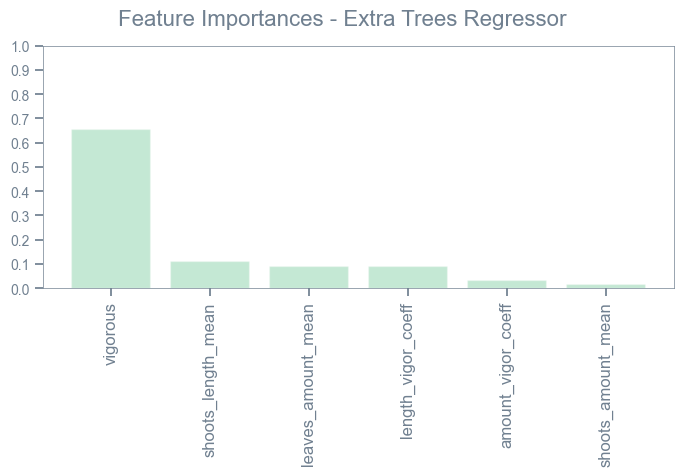

In [47]:
# Plot feature importances for the Extra Trees Regressor

# Create a plot
fig, ax = plt.subplots(figsize=(7, 5))

# Extract the feature importances and sort them
feature_importances = best_model_instance.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
feature_names = X.columns

ax.bar(
    range(len(feature_importances)), 
    sorted_importances, 
    tick_label=feature_names[sorted_indices], 
    color='mediumseagreen', 
    alpha=0.3
)

ax.set_xticks(range(len(feature_importances)))
ax.set_xticklabels(feature_names[sorted_indices], rotation=90, fontsize=12)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.tick_params(axis='y', labelsize=10)

# Color of the frame
frame_color = 'slategray'
for spine in ax.spines.values():
    spine.set_edgecolor(frame_color)

# Figure title
fig.suptitle(
    'Feature Importances - Extra Trees Regressor', 
    fontsize=16, 
    y=0.95, 
    color='slategray'
)        

plt.tight_layout()

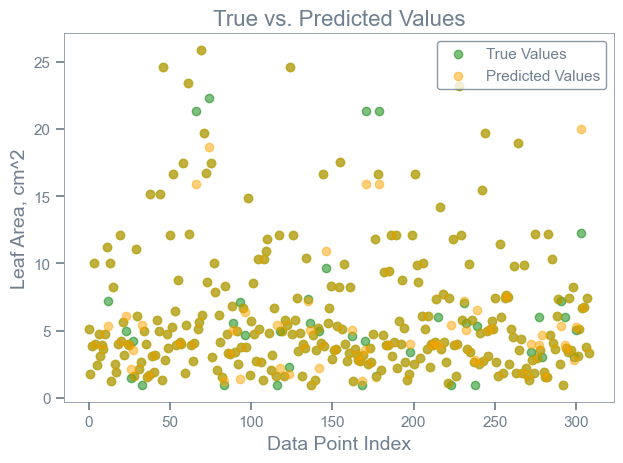

In [48]:
# Create scatter plots for true leaf areas and predicted leaf areas

# Predict values with the trained ExtraTreesRegressor model
y_pred_test = best_etreg.predict(X_test_scaled)

test['y_pred_test'] = y_pred_test

plt.scatter(
    test.index, 
    test['leaf_area_mean'], 
    color='green', 
    marker='o', 
    label='True Values', 
    alpha=0.5
)

plt.scatter(
    test.index, 
    test['y_pred_test'], 
    color='orange', 
    marker='o', 
    label='Predicted Values', 
    alpha=0.5
)

# Add labels and legend
plt.xlabel('Data Point Index', color = 'slategray', fontsize = 14)
plt.ylabel('Leaf Area, cm^2', color = 'slategray', fontsize = 14)
plt.title('True vs. Predicted Values', color = 'slategray', fontsize = 16)
plt.legend()

# Set color for axes and ticks
plt.gca().spines['bottom'].set_color('slategray')
plt.gca().spines['top'].set_color('slategray')
plt.gca().spines['left'].set_color('slategray')
plt.gca().spines['right'].set_color('slategray')
plt.gca().tick_params(axis='both', colors='slategray')

# Modify legend text color
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('slategray')

# Modify legend frame color
frame = legend.get_frame()
frame.set_edgecolor('slategray')

# Show the plot
plt.tight_layout()

**CONCLUSIONS from the visualization of the model performance:**

- **Leaf area per grape cutting is more accurately predicted for smaller (non-vigorous) leaves. Predicting the leaf area of larger leaves on vigorous plants is less precise, primarily due to the imbalanced dataset. Gathering more data from vigorous plants in the future will likely lead to more precise predictions.**

- **Plant vigor is the most influential feature for the ExtraTreesRegressor model, while shoot amount has the least impact.**

<div style="background-color: #b9deab; padding: 20px; border-radius: 10px; box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.2);">
    <h1 style="font-size: 20px; margin-bottom: 10px;"><u>CONCLUSIONS:</u></h1>
    <p style="font-size: 14px; line-height: 1.5;">
        <b>- An ExtraTreesRegressor model with default parameters can be used to predict leaf areas of Pinot Noir grapevine cuttings cultivated in the Odesa region.</b>
        <br><br>
        <b>- Feature engineering on the dataset is required by adding two new features that describe the relationships between vigor and other characteristics: length_vigor_coeff and amount_vigor_coeff.</b>
        <br><br>
        <b>- A Mean Absolute Error (MAE) around 0.24 is absolutely appropriate for this type of data, considering the high diversity of leaf sizes and shapes even on a single grapevine rooted cutting.</b>
        <br><br>
        <b>- The obtained models will significantly expedite field measurements, requiring only the counting of shoot and leaf amounts, measurement of shoot length, and overall estimation of plant vigor.</b>
        <br><br>
        <b>- If future model improvements are necessary, the training dataset should not be imbalanced: more data from vigorous plants must be collected.</b>
    </p>
</div>
